In [1]:
!git clone https://github.com/XL2248/MSCTD.git

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 12.30 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/train_ende.zip"
!unzip -q "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/test.zip"
!unzip -q "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/dev.zip"

In [4]:
# import packages
import os
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
import cv2 as cv
import cv2
import dlib
import re
from itertools import groupby
import pandas
from collections import Counter
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchsummary import summary 
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.nn.modules.container import Sequential
from torch.utils.data import Dataset, TensorDataset, DataLoader, ConcatDataset
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
from __future__ import print_function, division
import copy
import pathlib
from collections import Counter
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn import metrics
!pip install nltk
import nltk
nltk.download('punkt')
import pickle

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import os.path
import torch.nn.functional as F
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import math
import re
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


------------------------

english_dev : 5063

english_test : 5067

english_train : 20240

------------------

###Image Model

In [5]:
ToNumpy = lambda X=None : np.array(X)
y_h = lambda y : torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)
class MSCTDDataset(Dataset):

    def __init__(self, path_to_dataset = None, transform=None, target_transform=None):
        if path_to_dataset == 'path_to_dataset_train':
            Data = 'train'
            path_english_text = 'english_train'
            path_sentiment_text = 'sentiment_train'
            path_image = 'train_ende'
            path_image_index = "image_index_train"
        elif path_to_dataset == 'path_to_dataset_test':
            Data = 'test'
            path_download = 'test_ende'
            path_english_text = 'english_test'
            path_sentiment_text = 'sentiment_test'
            path_image = 'test'
            path_image_index = "image_index_test"
        elif path_to_dataset == 'path_to_dataset_dev':
            Data = 'dev'
            path_download = 'dev'
            path_english_text = 'english_dev'
            path_sentiment_text = 'sentiment_dev'
            path_image = 'dev'
            path_image_index = "image_index_dev"
        else:
            return TypeError, path_to_dataset + " is invalid"
        #!unzip "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/train_ende.zip"
        english_text_path = f"/content/MSCTD/MSCTD_data/ende/{path_english_text}.txt"
        sentiment_path = f"/content/MSCTD/MSCTD_data/ende/{path_sentiment_text}.txt"
        image_index_path = f"/content/MSCTD/MSCTD_data/ende/{path_image_index}.txt"
        self.image_path = f"/content/{path_image}/"

        with open(english_text_path) as f:
          english_text = [line.strip() for line in f.readlines()]
        print(f"{Data} english_text", len(english_text))
        self.englishtext = english_text

        with open(sentiment_path) as f:
          sentiment = [line.strip() for line in f.readlines()]
        self.sentiment = sentiment
        print(f"{Data} sentiment", len(sentiment))
        

        with open(image_index_path) as f:
          indexes = [line.strip() for line in f.readlines()]
        conv_index = []
        for lst in indexes:
          elements = re.findall(r'\d+', lst)
          res = [int(x) for x in elements]
          conv_index.append(res)
        self.conv_index = conv_index
        print(f"number of {Data} conversations", len(self.conv_index))
        # print(self.conv_index)
        Images = os.listdir(self.image_path)
        Images.sort(key = lambda x:  int(x.split(".")[0]))
        self.Images = Images
        # self.target = target
        # self.features = features
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        conversation_index = -1
        for i in range(len(self.conv_index)):
          if idx in self.conv_index[i]:
            conversation_index = i+1
            break
        img_path = os.path.join(self.image_path, self.Images[idx])

        img = cv.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Chnage channel due to imread function read images in BGR coding.
        sntmnt = self.sentiment[idx]
        englsh_txt = self.englishtext[idx]

        if self.target_transform:
            label = y_h(sntmnt)
        if self.transform:
            img = self.transform(img)
        return img, englsh_txt, sntmnt, conversation_index

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

###Image Model

In [7]:
use_pretrained = True
vgg16_pretrained = models.vgg16(pretrained=use_pretrained).to(device)
summary(vgg16_pretrained, (3, 64, 64))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [8]:
from torch.nn.modules.container import Sequential
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.features = vgg16_pretrained.features
        self.avgpool = nn.AdaptiveAvgPool2d(output_size =(2,2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=128, out_features=16, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=16, out_features=3, bias=True))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        y = self.classifier(x)
        return y

In [160]:
# Train
def train(address, early_stoping, patience, device, model, epochs, optimizer, loss_function, train_loader, valid_loader):
    size = len(train_loader.dataset)
    # Early stopping
    last_loss = 100
    last_acc = 0
    triggertimes = 0

    for epoch in range(1, epochs+1):
        model.train()
        correct = 0
        for times, (X, txt , sntmnt, dilog) in enumerate(train_loader, 1):
            y = []
            X = X.to(device)
            for lst in sntmnt:
              elements = re.findall(r'\d+', lst)
              res = [int(x) for x in elements]
              y.append(res[0])
            y = torch.tensor(y).to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            pred = model(X)
            loss = loss_function(pred, y)
            loss.backward()
            optimizer.step()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Show progress
            if times % 100 == 0 or times == len(train_loader):
                print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, times, len(train_loader), loss.item()))

        # Early stopping
        correct /= size
        current_loss, current_acc = validation(model, device, valid_loader, loss_function)
        print('[{}/{}]'.format(epoch, epochs))
        print('train loss: {:.8}   |||   train accuracy: {:.8}'.format(loss.item(), 100*correct))
        print('  dev loss: {:.8}   |||     dev accuracy: {:.8}'.format(current_loss, current_acc))

        if early_stoping == "loss":
          C = current_loss > last_loss
        elif early_stoping == "accuracy":
          C = current_acc < last_acc
        if C:
            trigger_times += 1
            print('Trigger Times:', trigger_times)
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return print(15*"=")
        else:
            torch.save(model, address)
            print('trigger times: 0')
            trigger_times = 0
            if early_stoping == "accuracy":
              last_acc = current_acc
            elif early_stoping == "loss":
              last_loss = current_loss
    best_model = model = torch.load(address)
    return print(15*"=")


def validation(model, device, dataloader, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, txt , sntmnt, dilog) in dataloader:
          X = X.to(device)
          y = []
          for lst in sntmnt:
            elements = re.findall(r'\d+', lst)
            res = [int(x) for x in elements]
            y.append(res[0])
          y = torch.tensor(y).to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, 100*correct

def test(device, model, dataloader, loss_fn):
    model.eval()
    true = []
    predicted = [] 
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, txt , sntmnt, dilog) in dataloader:
          X = X.to(device)
          y = []
          for lst in sntmnt:
            elements = re.findall(r'\d+', lst)
            res = [int(x) for x in elements]
            y.append(res[0])
          
          y = torch.tensor(y).to(device)
          pred = model(X)
          true.append(y)
          predicted.append(pred)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"test Error:  Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predicted, true

In [161]:
# GPU device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)

address = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/vgg_model1"
torch.manual_seed(65)
epochs = 100
batch_size = 64
image_size = (64, 64)
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
model = NeuralNetwork().to(device)
for param in model.features.parameters():
  param.requires_grad = False
for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | grad : {param.requires_grad} \n")
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size = image_size)])

Device state: cuda:0
Layer: features.0.weight | Size: torch.Size([64, 3, 3, 3]) | grad : False 

Layer: features.0.bias | Size: torch.Size([64]) | grad : False 

Layer: features.2.weight | Size: torch.Size([64, 64, 3, 3]) | grad : False 

Layer: features.2.bias | Size: torch.Size([64]) | grad : False 

Layer: features.5.weight | Size: torch.Size([128, 64, 3, 3]) | grad : False 

Layer: features.5.bias | Size: torch.Size([128]) | grad : False 

Layer: features.7.weight | Size: torch.Size([128, 128, 3, 3]) | grad : False 

Layer: features.7.bias | Size: torch.Size([128]) | grad : False 

Layer: features.10.weight | Size: torch.Size([256, 128, 3, 3]) | grad : False 

Layer: features.10.bias | Size: torch.Size([256]) | grad : False 

Layer: features.12.weight | Size: torch.Size([256, 256, 3, 3]) | grad : False 

Layer: features.12.bias | Size: torch.Size([256]) | grad : False 

Layer: features.14.weight | Size: torch.Size([256, 256, 3, 3]) | grad : False 

Layer: features.14.bias | Size: t

In [162]:
ToNumpy = lambda X=None : np.array(X)
y_h = lambda y : torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)
class MSCTDDataset(Dataset):

    def __init__(self, path_to_dataset = None, transform=None, target_transform=None):
        if path_to_dataset == 'path_to_dataset_train':
            Data = 'train'
            path_english_text = 'english_train'
            path_sentiment_text = 'sentiment_train'
            path_image = 'train_ende'
            path_image_index = "image_index_train"
        elif path_to_dataset == 'path_to_dataset_test':
            Data = 'test'
            path_download = 'test_ende'
            path_english_text = 'english_test'
            path_sentiment_text = 'sentiment_test'
            path_image = 'test'
            path_image_index = "image_index_test"
        elif path_to_dataset == 'path_to_dataset_dev':
            Data = 'dev'
            path_download = 'dev'
            path_english_text = 'english_dev'
            path_sentiment_text = 'sentiment_dev'
            path_image = 'dev'
            path_image_index = "image_index_dev"
        else:
            return TypeError, path_to_dataset + " is invalid"
        #!unzip "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/train_ende.zip"
        english_text_path = f"/content/MSCTD/MSCTD_data/ende/{path_english_text}.txt"
        sentiment_path = f"/content/MSCTD/MSCTD_data/ende/{path_sentiment_text}.txt"
        image_index_path = f"/content/MSCTD/MSCTD_data/ende/{path_image_index}.txt"
        self.image_path = f"/content/{path_image}/"

        with open(english_text_path) as f:
          english_text = [line.strip() for line in f.readlines()]
        print(f"{Data} english_text", len(english_text))
        self.englishtext = english_text

        with open(sentiment_path) as f:
          sentiment = [line.strip() for line in f.readlines()]
        self.sentiment = sentiment
        print(f"{Data} sentiment", len(sentiment))
        

        with open(image_index_path) as f:
          indexes = [line.strip() for line in f.readlines()]
        conv_index = []
        for lst in indexes:
          elements = re.findall(r'\d+', lst)
          res = [int(x) for x in elements]
          conv_index.append(res)
        self.conv_index = conv_index
        print(f"number of {Data} conversations", len(self.conv_index))
        # print(self.conv_index)
        Images = os.listdir(self.image_path)
        Images.sort(key = lambda x:  int(x.split(".")[0]))
        self.Images = Images
        # self.target = target
        # self.features = features
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        conversation_index = -1
        for i in range(len(self.conv_index)):
          if idx in self.conv_index[i]:
            conversation_index = i+1
            break
        img_path = os.path.join(self.image_path, self.Images[idx])

        img = cv.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Chnage channel due to imread function read images in BGR coding.
        sntmnt = self.sentiment[idx]
        englsh_txt = self.englishtext[idx]

        if self.target_transform:
            label = y_h(sntmnt)
        if self.transform:
            img = self.transform(img)
        return img, englsh_txt, sntmnt, conversation_index

In [169]:
# Data
training_data = MSCTDDataset('path_to_dataset_train', target_transform = False, transform = transform)
test_data = MSCTDDataset('path_to_dataset_test', target_transform = False, transform = transform)
dev_data = MSCTDDataset('path_to_dataset_dev', target_transform = False, transform = transform)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)
dev_dataloader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)


train english_text 20240
train sentiment 20240
number of train conversations 2066
test english_text 5067
test sentiment 5067
number of test conversations 509
dev english_text 5063
dev sentiment 5063
number of dev conversations 504


In [ ]:
# Train
print("\n\nTraining...")

early_stoping = "accuracy"
patience = 2
train(address, early_stoping, patience, device, model, epochs, optimizer, loss_fn, train_dataloader, dev_dataloader)
best_model = torch.load(address)

In [170]:
# Test
predicted, true = test(device, best_model, test_dataloader, loss_fn)

test Error:  Accuracy: 40.8%, Avg loss: 1.095211 



In [ ]:
true

In [172]:
y_tr = [i.item() for i in true]
y_pr = [torch.argmax(i[0]).item() for i in predicted]

In [175]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_tr, y_pr))
print(confusion_matrix(y_tr, y_pr))

              precision    recall  f1-score   support

           0       0.26      0.16      0.20      1298
           1       0.44      0.86      0.58      2163
           2       0.00      0.00      0.00      1606

    accuracy                           0.41      5067
   macro avg       0.23      0.34      0.26      5067
weighted avg       0.25      0.41      0.30      5067

[[ 211 1087    0]
 [ 305 1858    0]
 [ 284 1322    0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
best_model = torch.load("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/Parvizi_Part2", map_location=torch.device('cuda'))

# Test
predicted, true = test(device, best_model, test_dataloader, loss_fn)

test Error:  Accuracy: 41.1%, Avg loss: 1.094047 



In [63]:
y_tr = [i.item() for i in true]
y_pr = [torch.argmax(i[0]).item() for i in predicted]

In [66]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_tr, y_pr))
print(confusion_matrix(y_tr, y_pr))

              precision    recall  f1-score   support

           0       0.28      0.14      0.19      1298
           1       0.43      0.88      0.58      2163
           2       0.00      0.00      0.00      1606

    accuracy                           0.41      5067
   macro avg       0.24      0.34      0.26      5067
weighted avg       0.26      0.41      0.30      5067

[[ 188 1110    0]
 [ 267 1896    0]
 [ 221 1385    0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Text Model

In [ ]:
seed = 68
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from torchtext.data import get_tokenizer
# from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator

In [69]:
y_h = lambda y : torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)
class MSCTDDataset(Dataset):

    def __init__(self, path_to_dataset = None, transform=None, target_transform=None):
        if path_to_dataset == 'path_to_dataset_train':
            Data = 'train'
            path_english_text = 'english_train'
            path_sentiment_text = 'sentiment_train'
            path_image = 'train_ende'
            path_image_index = "image_index_train"
        elif path_to_dataset == 'path_to_dataset_test':
            Data = 'test'
            path_download = 'test_ende'
            path_english_text = 'english_test'
            path_sentiment_text = 'sentiment_test'
            path_image = 'test'
            path_image_index = "image_index_test"
        elif path_to_dataset == 'path_to_dataset_dev':
            Data = 'dev'
            path_download = 'dev'
            path_english_text = 'english_dev'
            path_sentiment_text = 'sentiment_dev'
            path_image = 'dev'
            path_image_index = "image_index_dev"
        else:
            return TypeError, path_to_dataset + " is invalid"
        #!unzip "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/train_ende.zip"
        english_text_path = f"/content/MSCTD/MSCTD_data/ende/{path_english_text}.txt"
        sentiment_path = f"/content/MSCTD/MSCTD_data/ende/{path_sentiment_text}.txt"
        image_index_path = f"/content/MSCTD/MSCTD_data/ende/{path_image_index}.txt"
        self.image_path = f"/content/{path_image}/"

        with open(english_text_path) as f:
          english_text = [line.strip() for line in f.readlines()]
        print(f"{Data} english_text", len(english_text))
        self.englishtext = english_text

        with open(sentiment_path) as f:
          sentiment = [line.strip() for line in f.readlines()]
        self.sentiment = sentiment
        print(f"{Data} sentiment", len(sentiment))
        with open(image_index_path) as f:
          indexes = [line.strip() for line in f.readlines()]
        conv_index = []
        for lst in indexes:
          elements = re.findall(r'\d+', lst)
          res = [int(x) for x in elements]
          conv_index.append(res)
        self.conv_index = conv_index
        print(f"number of {Data} conversations", len(self.conv_index))
        Images = os.listdir(self.image_path)
        Images.sort(key = lambda x:  int(x.split(".")[0]))
        self.Images = Images
        self.transform = transform
        self.target_transform = target_transform
        transform = transforms.Compose([transforms.ToTensor()])
    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        conversation_index = -1
        for i in range(len(self.conv_index)):
          if idx in self.conv_index[i]:
            conversation_index = i+1
            break
        sntmnt = self.sentiment[idx]
        englsh_txt = self.englishtext[idx]

        if self.target_transform:
            label = y_h(sntmnt)
        return englsh_txt, sntmnt, conversation_index

In [70]:
train_ = MSCTDDataset('path_to_dataset_train', target_transform = False)
test_ = MSCTDDataset('path_to_dataset_test', target_transform = False)
dev_ = MSCTDDataset('path_to_dataset_dev', target_transform = False)

train english_text 20240
train sentiment 20240
number of train conversations 2066
test english_text 5067
test sentiment 5067
number of test conversations 509
dev english_text 5063
dev sentiment 5063
number of dev conversations 504


In [71]:
eng_list=[x[0] for x in train_]
lable_list=[x[1] for x in train_]
train_label = [eval(i) for i in lable_list]
cnvr_list=[x[2] for x in train_]

In [72]:
len(list(set(cnvr_list)))

2066

In [73]:
tokenizer = get_tokenizer("basic_english")
def build_vocab(datasets):
  for _, text in datasets:
    yield tokenizer(text)
sentences = enumerate(eng_list)
token_generator = build_vocab(sentences)
vocab = build_vocab_from_iterator(token_generator,
                                  min_freq=1,
                                  specials=['<sos>', '<eos>', '<unk>'])
vocab.set_default_index(vocab["<unk>"])

In [74]:
print("vocab length", len(vocab))
print("index of <ali>", vocab["ali"])
print("index of <unk>", vocab["<unk>"])
print("index of <sos>", vocab["<sos>"])
print("index of <eos>", vocab["<eos>"])

vocab length 9874
index of <ali> 2
index of <unk> 2
index of <sos> 0
index of <eos> 1


In [79]:
SVM = pickle.load(open("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/embedding_vec_2.p", "rb"))

In [ ]:
print(SVM["<eos>"])
print(SVM["<sos>"])
print(SVM["<unk>"].shape)

[[-3.34279203e-04  9.66934375e-05  9.09144688e-04 ... -4.08905359e-03
  -9.13396576e-04  0.00000000e+00]]
[[ 1.88680133e-03  7.24659124e-05  4.27327657e-04 ...  7.18038536e-04
  -1.03761044e-04  0.00000000e+00]]
(1, 2067)


In [80]:
def vectorize_batch(batch):
    length = 15
    res = [[j for j, k, l in batch], [k for j, k, l  in batch]]
    # print(res[0])
    X, Y = res[0], res[1]
    Y = [eval(i) for i in Y]
    X = [re.sub(r'[^\w\s]','', sntnce) for sntnce in X]
    X = [re.sub(r'\d+', '', sntnce) for sntnce in X]
    X = [sntnce.lower() for sntnce in X]
    X = [nltk.tokenize.word_tokenize(sample) for sample in X]
    # print(X)
    X = [vocab(sample) for sample in X]
    # print(X)
    X = [sample+([2]* (length-len(sample))) if len(sample) < length else sample[:length] for sample in X]
    [x.append(1) for x in X]
    [x.insert(0,0) for x in X]
    return torch.tensor(X, dtype=torch.int32).transpose(0, 1).to(device), torch.tensor(Y, dtype=torch.int32).to(device)
# train_data, test_data, val_data = to_map_style_dataset(train_data), to_map_style_dataset(test_data), to_map_style_dataset(val_data)
train = MSCTDDataset('path_to_dataset_train', target_transform = False)
test = MSCTDDataset('path_to_dataset_test', target_transform = False)
dev = MSCTDDataset('path_to_dataset_dev', target_transform = False)

train_loader = DataLoader(train, batch_size=512, collate_fn=vectorize_batch)
test_loader  = DataLoader(test, batch_size=512, collate_fn=vectorize_batch)
val_loader  = DataLoader(dev, batch_size=512, collate_fn=vectorize_batch)

train english_text 20240
train sentiment 20240
number of train conversations 2066
test english_text 5067
test sentiment 5067
number of test conversations 509
dev english_text 5063
dev sentiment 5063
number of dev conversations 504


In [81]:
class BiDGRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional= True)
        self.fc1 = nn.Linear(hid_dim * 2, hid_dim)
        self.fc2 = nn.Linear(hid_dim, 3)
        self.probs = nn.Softmax(dim=1)
    def forward(self, src):
        s = self.embedding(src)
        embedded = self.dropout(s)
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc1(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        hidden = self.fc2(hidden)
        probabilities = self.probs(hidden)
        return probabilities

In [82]:
seed = 59
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

input_dim = len(vocab)
output_dim = len(vocab)
enc_emb_dim = 256
dec_emb_dim = 256
hid_dim = 512
enc_dropout = 0.5
dec_dropout = 0.5

model = BiDGRU(len(vocab), 256, 512, 0.5).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

BiDGRU(
  (embedding): Embedding(9874, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): GRU(256, 512, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (probs): Softmax(dim=1)
)

In [83]:
optimizer = optim.Adam(model.parameters())
target_padding_index = vocab.get_stoi()["<unk>"]
criterion = nn.CrossEntropyLoss(ignore_index = target_padding_index).to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [84]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [85]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    ns = 0
    aize = len(iterator)
    correct = 0
    for i, batch in enumerate(iterator):
        src, trg = batch
        optimizer.zero_grad()
        output = model(src)
        output_dim = output.shape[-1]
        output = output[1:,].view(-1, output_dim)
        trg = trg[1:,].reshape(output.shape[0])
        trg = trg.type(torch.LongTensor).to(device)
        loss = criterion(output, trg)
        correct += (output.argmax(1) == trg).type(torch.float).sum().item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        ns += src.shape[1]
        epoch_loss += loss.item()
    correct /= ns
    return correct, epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    correct = 0
    ns = 0
    true, predicted = [], []
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            src, trg = batch
            output = model(src)
            output_dim = output.shape[-1]
            output = output.view(-1, output_dim)
            true.append(trg)
            predicted.append(output)
            trg = trg.reshape(output.shape[0])
            trg = trg.type(torch.LongTensor).to(device)
            loss = criterion(output, trg)
            correct += (output.argmax(1) == trg).sum().item()
            ns += src.shape[1]
            epoch_loss += loss.item()
    correct /= ns
    return true, predicted, correct , epoch_loss / len(iterator)

Epoch: 01 | Time: 0m 9s
	Train Loss: 1.089 | Train PPL:   2.973 | Train acc: 0.400
	 Val. Loss: 1.098 |  Val. PPL:   2.999 | Val acc: 0.370
Epoch: 02 | Time: 0m 7s
	Train Loss: 1.036 | Train PPL:   2.818 | Train acc: 0.456
	 Val. Loss: 1.049 |  Val. PPL:   2.854 | Val acc: 0.443
Epoch: 03 | Time: 0m 9s
	Train Loss: 0.987 | Train PPL:   2.683 | Train acc: 0.518
	 Val. Loss: 1.033 |  Val. PPL:   2.810 | Val acc: 0.470
Epoch: 04 | Time: 0m 9s
	Train Loss: 0.938 | Train PPL:   2.554 | Train acc: 0.595
	 Val. Loss: 1.036 |  Val. PPL:   2.817 | Val acc: 0.493
Epoch: 05 | Time: 0m 7s
	Train Loss: 0.920 | Train PPL:   2.509 | Train acc: 0.619
	 Val. Loss: 1.124 |  Val. PPL:   3.076 | Val acc: 0.417
Epoch: 06 | Time: 0m 9s
	Train Loss: 0.961 | Train PPL:   2.615 | Train acc: 0.580
	 Val. Loss: 1.033 |  Val. PPL:   2.808 | Val acc: 0.505
Epoch: 07 | Time: 0m 8s
	Train Loss: 0.899 | Train PPL:   2.458 | Train acc: 0.640
	 Val. Loss: 1.027 |  Val. PPL:   2.793 | Val acc: 0.510
Epoch: 08 | Time: 0m

[]

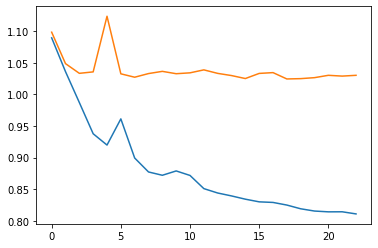

In [ ]:
N_EPOCHS = 23
CLIP = 1

best_valid_loss = float('inf')
train_history = []
val_history = []
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_acc, train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    model.eval()
    _,_,val_acc, valid_loss = evaluate(model, val_loader, criterion)
    train_history += [train_loss]
    val_history += [valid_loss]
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | Val acc: {val_acc:.3f}')
plt.plot(range(epoch+1), train_history)
plt.plot(range(epoch+1), val_history)
plt.plot()

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))
true, predicted, acc, test_loss = evaluate(model, test_loader, criterion)

In [ ]:
print(f"{100*acc:.1f}%")

51.8%


In [ ]:
y_tr = [int(torch.max(i).item()) for i in true]
y_pr = [int(torch.max(i).item()) for i in predicted]

In [ ]:
true_ = []
for i in true:
  i.tolist()
  true_.extend(i.tolist())

predicted_ = []
for i in predicted:
  predicted_.extend(torch.argmax(i,1).tolist())

In [ ]:
len(predicted_)

5067

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(true_, predicted_))
print(confusion_matrix(true_, predicted_))

              precision    recall  f1-score   support

           0       0.38      0.42      0.40      1298
           1       0.61      0.61      0.61      2163
           2       0.53      0.47      0.50      1606

    accuracy                           0.52      5067
   macro avg       0.50      0.50      0.50      5067
weighted avg       0.52      0.52      0.52      5067

[[ 545  435  318]
 [ 474 1321  368]
 [ 426  420  760]]


In [ ]:
torch.save(model, "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/text_model.pkl")

###Domain Adaptation via Weakly Supervised Learning

COCO Dataset

In [86]:
#           annotations_trainval2014.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!rm annotations_trainval2014.zip

--2023-02-12 08:24:14--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.33.33, 52.216.245.116, 54.231.131.201, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.33.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  33.5MB/s    in 7.9s    

2023-02-12 08:24:22 (30.4 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

Archive:  /content/annotations_trainval2014.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


In [87]:
#                 train2014.zip

!wget http://images.cocodataset.org/zips/train2014.zip
!unzip -q /content/train2014.zip
!rm train2014.zip

--2023-02-12 08:24:31--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.93.20, 52.216.133.219, 52.217.68.76, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.93.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  33.8MB/s    in 6m 37s  

2023-02-12 08:31:08 (32.5 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [88]:
#                 COCO dataset

!git clone https://github.com/cocodataset/cocoapi.git
!coco/PythonAPI
!make

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 22.65 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/bin/bash: coco/PythonAPI: No such file or directory
make: *** No targets specified and no makefile found.  Stop.


In [89]:
class Vocabulary(object):

    def __init__(self, vocab_threshold, vocab_file='/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw4/vocab.pkl',
        start_word="<sos>", end_word="<eos>", unk_word="<unk>",
        annotations_file='/content/annotations/captions_train2014.json', vocab_from_file=False):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            # Remove punctuation by using regex
            rp_caption = re.sub(r'[^\w\s]','',caption)
            #remove numbers
            rnp_caption = re.sub(r'\d+', '', rp_caption)
            tokens = nltk.tokenize.word_tokenize(rnp_caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [90]:
class CoCoDataset(data.Dataset):

    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]

    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

---------------------------------------------------------

In [91]:
# Text Network
class BiDGRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional= True)
        self.fc1 = nn.Linear(hid_dim * 2, hid_dim)
        self.fc2 = nn.Linear(hid_dim, 3)
        self.probs = nn.Softmax(dim=1)
    def forward(self, src):
        s = self.embedding(src)
        embedded = self.dropout(s)
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc1(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        hidden = self.fc2(hidden)
        probabilities = self.probs(hidden)
        return probabilities

In [92]:
# Image Network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.features = vgg16_pretrained.features
        self.avgpool = nn.AdaptiveAvgPool2d(output_size =(2,2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=128, out_features=16, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=16, out_features=3, bias=True))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        y = self.classifier(x)
        return y

In [95]:
text_model = torch.load("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/text_model.pkl")
image_model = torch.load("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/Parvizi_Part2", map_location=torch.device('cuda'))

In [96]:
for param in image_model.features.parameters():
  param.requires_grad = False
for name, param in image_model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | grad : {param.requires_grad} \n")

Layer: features.0.weight | Size: torch.Size([64, 3, 3, 3]) | grad : False 

Layer: features.0.bias | Size: torch.Size([64]) | grad : False 

Layer: features.2.weight | Size: torch.Size([64, 64, 3, 3]) | grad : False 

Layer: features.2.bias | Size: torch.Size([64]) | grad : False 

Layer: features.5.weight | Size: torch.Size([128, 64, 3, 3]) | grad : False 

Layer: features.5.bias | Size: torch.Size([128]) | grad : False 

Layer: features.7.weight | Size: torch.Size([128, 128, 3, 3]) | grad : False 

Layer: features.7.bias | Size: torch.Size([128]) | grad : False 

Layer: features.10.weight | Size: torch.Size([256, 128, 3, 3]) | grad : False 

Layer: features.10.bias | Size: torch.Size([256]) | grad : False 

Layer: features.12.weight | Size: torch.Size([256, 256, 3, 3]) | grad : False 

Layer: features.12.bias | Size: torch.Size([256]) | grad : False 

Layer: features.14.weight | Size: torch.Size([256, 256, 3, 3]) | grad : False 

Layer: features.14.bias | Size: torch.Size([256]) | gr

In [97]:
transform_train = transforms.Compose([
    transforms.Resize(72),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [99]:
# vocab_file = '/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/hw4/vocab.pkl'
# annotations_file = '/content/annotations/captions_train2014.json'
# img_folder = '/content/images/test2014/'
num_workers = 0

train_dataset = CoCoDataset(transform=transform_train,
                          mode='train',
                          batch_size=64,
                          vocab_threshold=6,
                          vocab_file='/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/vocab.pkl',
                          start_word='<sos>',
                          end_word='<eos>',
                          unk_word='<ukn>',
                          annotations_file="/content/annotations/captions_train2014.json",
                          vocab_from_file=False,
                          img_folder='/content/train2014/')
print("Vocabulary is creaated!")

loading annotations into memory...
Done (t=1.05s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=1.09s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:49<00:00, 8400.66it/s] 


Vocabulary is creaated!


In [100]:
train_dataset = CoCoDataset(transform=transform_train,
                          mode='train', batch_size=64, vocab_threshold=6,
                          vocab_file='/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/vocab.pkl',
                          start_word='<sos>', end_word='<eos>', unk_word='<ukn>',
                          annotations_file="/content/annotations/captions_train2014.json",
                          vocab_from_file=True, img_folder='/content/train2014/')
indices = train_dataset.get_train_indices()
initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
unlabeled_data_loader = data.DataLoader(dataset=train_dataset,
                              num_workers=0,
                              batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,batch_size=train_dataset.batch_size,drop_last=False))

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:46<00:00, 8822.33it/s] 


In [101]:
def test(device, model, dataloader, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    predicted, true = [], []
    with torch.no_grad():
        for (X, txt , sntmnt, dilog) in dataloader:
          X = X.to(device)
          y = []
          for lst in sntmnt:
            elements = re.findall(r'\d+', lst)
            res = [int(x) for x in elements]
            y.append(res[0])
          y = torch.tensor(y).to(device)
          pred = model(X)
          true.append(y)
          predicted.append(pred)
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"test Error:  Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predicted, true

In [102]:
predicted, true = test(device, best_model, test_dataloader, loss_fn)

test Error:  Accuracy: 41.1%, Avg loss: 1.093797 



In [103]:
image_model = torch.load("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/project/Parvizi_Part2", map_location=torch.device('cuda'))

In [104]:
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
params =list(image_model.classifier.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001, betas=(0.9, 0.999), eps=1e-08)

In [ ]:
num_epochs = 1
print_every = 200
vocab_size = len(unlabeled_data_loader.dataset.vocab)
total_step = math.ceil(len(unlabeled_data_loader.dataset.caption_lengths) / unlabeled_data_loader.batch_sampler.batch_size)
for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):

        indices = unlabeled_data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        unlabeled_data_loader.batch_sampler.sampler = new_sampler
        images, captions = next(iter(unlabeled_data_loader))
        images = images.to(device)
        captions = captions.to(device)
        image_model.zero_grad()
        # outputs = image_model(images, captions)
        outputs = image_model(images)
        target = text_model(captions.T)
        # values, indices = torch.max(target, axis=1)
        loss = criterion(outputs, target.detach())
        loss.backward()
        optimizer.step()
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        print('\r' + stats, end="")
        sys.stdout.flush()
        if i_step % print_every == 0:
            print('\r' + stats)

Epoch [1/1], Step [200/6471], Loss: 0.9699, Perplexity: 2.6377
Epoch [1/1], Step [400/6471], Loss: 1.0545, Perplexity: 2.8707
Epoch [1/1], Step [600/6471], Loss: 1.0073, Perplexity: 2.7381
Epoch [1/1], Step [800/6471], Loss: 1.0268, Perplexity: 2.7921
Epoch [1/1], Step [1000/6471], Loss: 1.0433, Perplexity: 2.8385
Epoch [1/1], Step [1200/6471], Loss: 1.0352, Perplexity: 2.8158
Epoch [1/1], Step [1400/6471], Loss: 1.0430, Perplexity: 2.8378
Epoch [1/1], Step [1600/6471], Loss: 0.9722, Perplexity: 2.6438
Epoch [1/1], Step [1800/6471], Loss: 1.0781, Perplexity: 2.9391
Epoch [1/1], Step [2000/6471], Loss: 1.0085, Perplexity: 2.7416
Epoch [1/1], Step [2200/6471], Loss: 0.9664, Perplexity: 2.6285
Epoch [1/1], Step [2400/6471], Loss: 0.9697, Perplexity: 2.6373
Epoch [1/1], Step [2600/6471], Loss: 1.0735, Perplexity: 2.9255
Epoch [1/1], Step [2800/6471], Loss: 0.9598, Perplexity: 2.6111
Epoch [1/1], Step [3000/6471], Loss: 1.0649, Perplexity: 2.9006
Epoch [1/1], Step [3200/6471], Loss: 1.0614,

In [ ]:
predicted, true = test(device, image_model, test_dataloader, loss_fn)

test Error:  Accuracy: 42.7%, Avg loss: 1.081796 

